In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230309_160455.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230309_143550.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230309_162259.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230302_171245.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230309_155231.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230309_161707.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230302_171127.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230309_155323.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230309_160654.jpg
/kaggle/input/validation-set-small/validation_data_tomato_small_2/unriped/IMG_20230309_155819.jpg
/kaggle/input/valida

# Create a basline CNN to predict ripeness of tomatoes

- ResNet
- Dropout
- L2 Regularization
- Learning Rate Scheduler

In [53]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from copy import deepcopy
from tqdm import tqdm
from PIL import Image

In [54]:
seed = 1

# Set device to use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
else: 
    device = torch.device('cpu')

torch.manual_seed(seed)

print(device)

cuda


In [55]:
# Enforce deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Setup

In [56]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [57]:
# Load labeled datasets
labeled_data_dir = '/kaggle/input/tomato-dataset-full/data/labeled-data'
labeled_dataset = datasets.ImageFolder(labeled_data_dir, transform=transform)

In [58]:
# Split labeled data into training and testing datasets
train_size = int(0.8 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size
train_dataset, test_dataset = random_split(labeled_dataset, [train_size, test_size])

In [59]:
# DataLoader with worker_init_fn
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    torch.manual_seed(seed + worker_id)

In [60]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

print('Num Labeled: ', len(labeled_dataset))

Num Labeled:  177


## Define Model

In [61]:
# Define the ResNet model with dropout
class ResNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetModel, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [62]:
# Instantiate model, loss function, optimizer, and metrics
model = ResNetModel(num_classes=2).to(device)

## Train Model

In [63]:
# Training function with tqdm
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=35):
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    train_accuracy = torchmetrics.Accuracy(task='binary').to(device)
    test_accuracy = torchmetrics.Accuracy(task='binary').to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        
        # Training phase
        model.train()
        running_loss = 0.0
        train_accuracy.reset()
        
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            preds = torch.argmax(outputs, dim=1)
            train_accuracy.update(preds, labels)
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = train_accuracy.compute().item()
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        test_accuracy.reset()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Validation', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)
                test_accuracy.update(preds, labels)
                running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = test_accuracy.compute().item()
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses, train_accuracies, test_accuracies

In [64]:
# Instantiate model, loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [65]:
# Train and evaluate the model
trained_model, train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler)

Epoch 1/35


Training Loss: 0.4428 Acc: 0.8511


Validation Loss: 0.3811 Acc: 0.8611
Epoch 2/35


Training Loss: 0.2737 Acc: 0.9007


Validation Loss: 2.4407 Acc: 0.7778
Epoch 3/35


Training Loss: 0.1465 Acc: 0.9574


Validation Loss: 0.6172 Acc: 0.9444
Epoch 4/35


Training Loss: 0.1887 Acc: 0.9574


Validation Loss: 1.3579 Acc: 0.8056
Epoch 5/35


Training Loss: 0.0651 Acc: 0.9787


Validation Loss: 1.5309 Acc: 0.8889
Epoch 6/35


Training Loss: 0.0778 Acc: 0.9716


Validation Loss: 0.5543 Acc: 0.9722
Epoch 7/35


Training Loss: 0.0510 Acc: 0.9787


Validation Loss: 0.1249 Acc: 0.9722
Epoch 8/35


Training Loss: 0.1457 Acc: 0.9574


Validation Loss: 0.2994 Acc: 0.9722
Epoch 9/35


Training Loss: 0.2989 Acc: 0.9291


Validation Loss: 0.3526 Acc: 0.9444
Epoch 10/35


Training Loss: 0.0844 Acc: 0.9787


Validation Loss: 0.0980 Acc: 0.9722
Epoch 11/35


Training Loss: 0.0563 Acc: 0.9929


Validation Loss: 0.1236 Acc: 0.9722
Epoch 12/35


Training Loss: 0.0886 Acc: 0.9858


Validation Loss: 0.1570 Acc: 0.9722
Epoch 13/35


Training Loss: 0.0668 Acc: 0.9787


Validation Loss: 0.1560 Acc: 0.9722
Epoch 14/35


Training Loss: 0.0372 Acc: 0.9929


Validation Loss: 0.1413 Acc: 0.9722
Epoch 15/35


Training Loss: 0.0438 Acc: 0.9929


Validation Loss: 0.1610 Acc: 0.9722
Epoch 16/35


Training Loss: 0.0585 Acc: 0.9929


Validation Loss: 0.1389 Acc: 0.9722
Epoch 17/35


Training Loss: 0.0381 Acc: 0.9929


Validation Loss: 0.1372 Acc: 0.9722
Epoch 18/35


Training Loss: 0.0354 Acc: 0.9929


Validation Loss: 0.1447 Acc: 0.9722
Epoch 19/35


Training Loss: 0.0304 Acc: 0.9929


Validation Loss: 0.1703 Acc: 0.9722
Epoch 20/35


Training Loss: 0.0427 Acc: 0.9929


Validation Loss: 0.1867 Acc: 0.9722
Epoch 21/35


Training Loss: 0.0289 Acc: 0.9929


Validation Loss: 0.1870 Acc: 0.9722
Epoch 22/35


Training Loss: 0.0451 Acc: 0.9787


Validation Loss: 0.1897 Acc: 0.9722
Epoch 23/35


Training Loss: 0.0315 Acc: 0.9929


Validation Loss: 0.1545 Acc: 0.9722
Epoch 24/35


Training Loss: 0.0590 Acc: 0.9858


Validation Loss: 0.1571 Acc: 0.9722
Epoch 25/35


Training Loss: 0.0233 Acc: 0.9929


Validation Loss: 0.1605 Acc: 0.9722
Epoch 26/35


Training Loss: 0.0335 Acc: 0.9929


Validation Loss: 0.1887 Acc: 0.9722
Epoch 27/35


Training Loss: 0.0413 Acc: 0.9929


Validation Loss: 0.1838 Acc: 0.9722
Epoch 28/35


Training Loss: 0.0437 Acc: 0.9929


Validation Loss: 0.1867 Acc: 0.9722
Epoch 29/35


Training Loss: 0.0387 Acc: 0.9929


Validation Loss: 0.1606 Acc: 0.9722
Epoch 30/35


Training Loss: 0.0364 Acc: 0.9929


Validation Loss: 0.1929 Acc: 0.9722
Epoch 31/35


Training Loss: 0.0305 Acc: 0.9929


Validation Loss: 0.1956 Acc: 0.9722
Epoch 32/35


Training Loss: 0.0601 Acc: 0.9858


Validation Loss: 0.1881 Acc: 0.9722
Epoch 33/35


Training Loss: 0.0352 Acc: 0.9858


Validation Loss: 0.1916 Acc: 0.9722
Epoch 34/35


Training Loss: 0.0337 Acc: 0.9929


Validation Loss: 0.1633 Acc: 0.9722
Epoch 35/35


Training Loss: 0.0329 Acc: 0.9929


Validation Loss: 0.1555 Acc: 0.9722


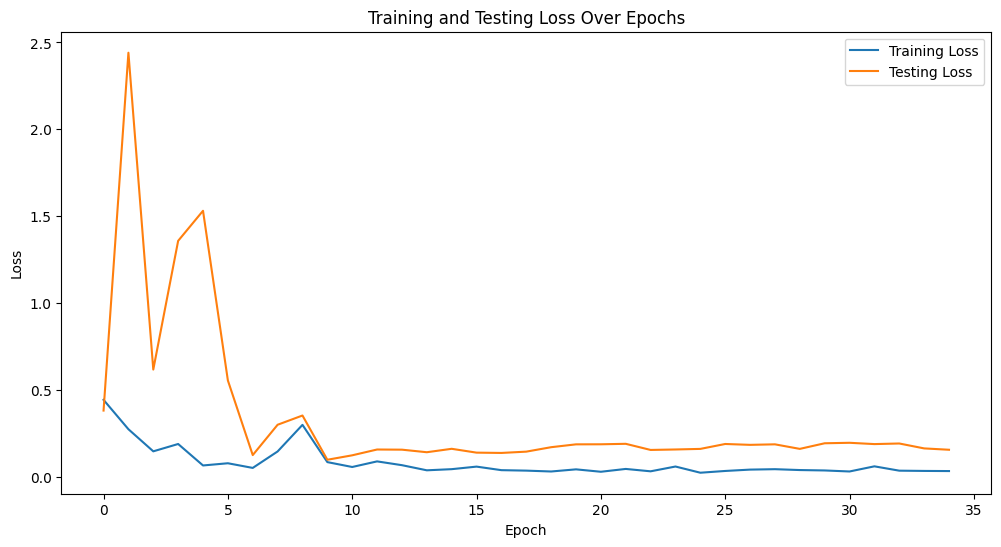

In [66]:
# Plot training and testing loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss Over Epochs')
plt.show()

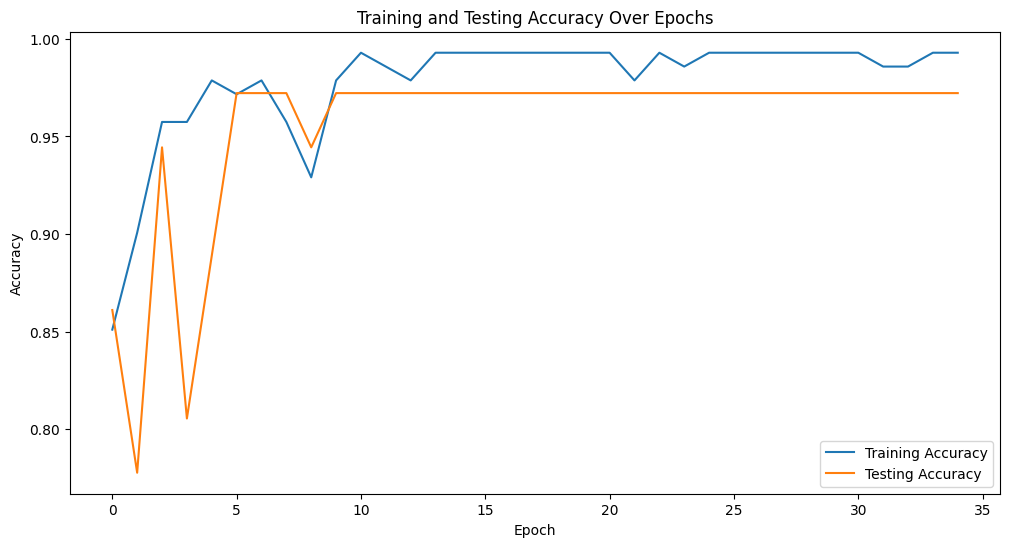

In [67]:
# Plot training and testing accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.show()

## Validate

In [68]:
# Evaluate on validation set
validation_dir = '/kaggle/input/tomato-dataset-full/data/validation-data'
validation_dataset = datasets.ImageFolder(validation_dir, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn)

In [69]:
print('Validation Dataset Length: ', len(validation_dataset))

Validation Dataset Length:  2000


In [70]:
# Evaluate on validation set and display images
def evaluate_and_display(model, validation_loader, num_images=16):
    model.eval()
    val_accuracy = torchmetrics.Accuracy(task='binary').to(device)
    all_labels, all_preds, all_probs = [], [], []
    images = []
    num_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            val_accuracy.update(preds, labels)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            images.extend(inputs.cpu())
            num_samples += len(labels)

    val_acc = val_accuracy.compute().item()
    print(f'Validation Accuracy: {val_acc:.4f}')
    print(f'Number of samples validated on: {num_samples}')

    # Display images
    def unnormalize(img):
        mean = torch.tensor([0.485, 0.456, 0.406]).to(img.device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(img.device)
        img = img * std[:, None, None] + mean[:, None, None]
        return img

    # Ensure num_images is not larger than the number of images
    if num_images > len(images):
        print(f"Batch size is smaller than num_images. Displaying {len(images)} images instead.")
        num_images = len(images)

    indices = random.sample(range(len(images)), num_images)
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img = unnormalize(images[idx]).permute(1, 2, 0).numpy()
        ax.imshow(img)
        pred_class = "Riped" if all_preds[idx] == 0 else "Unriped"
        true_class = "Riped" if all_labels[idx] == 0 else "Unriped"
        confidence = np.max(all_probs[idx])
        ax.set_title(f'Predicted: {pred_class} ({confidence:.2f})\nActual: {true_class}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Validation Accuracy: 0.9125
Number of samples validated on: 2000


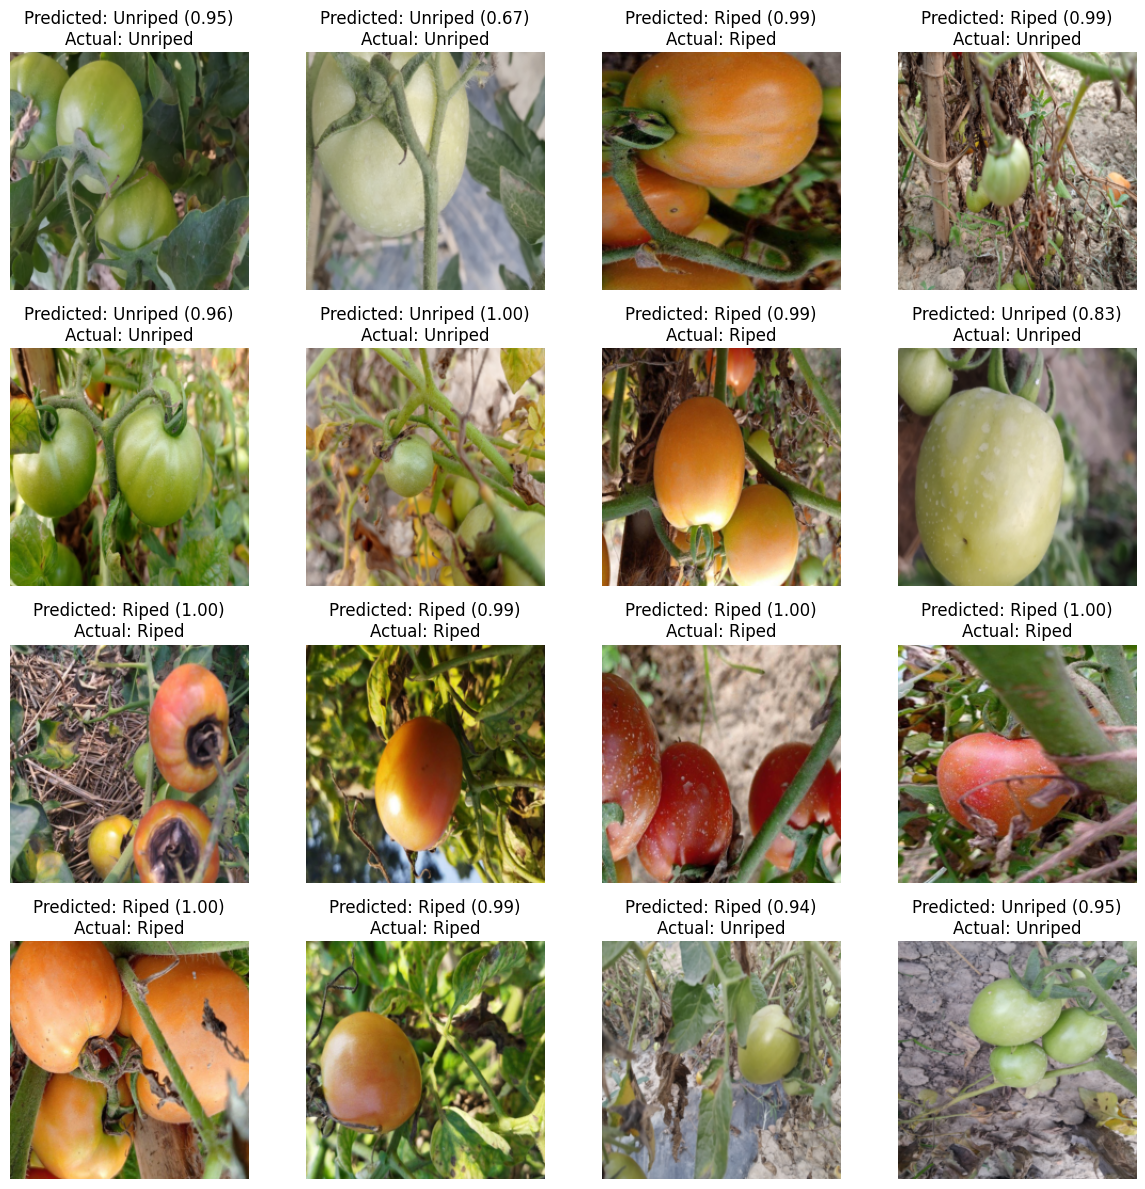

In [71]:
# Evaluate and display
evaluate_and_display(trained_model, validation_loader)